In [77]:
#final code

from openai import OpenAI
from datasets import load_dataset
import json
import time
import re

# Initialize the OpenAI client
openAI_client = OpenAI()
deepSeek_client = client = OpenAI(api_key="<api_key>", base_url="https://api.deepseek.com")

# Load the dataset
ds = load_dataset("nlile/24-game")
rows = ds["train"].select(range(20))  # Select the first 2 rows for testing

def preprocess_gpt_response(response):
    """
    Preprocess GPT response to remove code block markers and ensure valid JSON format.
    """
    # Remove surrounding backticks and 'json' markers
    response_cleaned = re.sub(r"^```(json)?|```$", "", response.strip())
    return response_cleaned
    
# Define a function to test the model with a single input
def test_model(numbers, client, modelName):
    prompt = f"""
    You are an expert at solving the game of 24. 
    The task is to determine if the four given numbers can be used with basic arithmetic operations (+, -, *, /) to form the number 24, 
    every number can only be used once.
    Your response must contain nothing but a JSON string using double quotes for keys and values.
    - If not solvable, return: {{"solvable": false}}
    - If solvable, return: {{"solvable": true, "solutions": ["solution1", "solution2", ...]}}
    
    Do not provide any explanation, context, or additional text outside of the JSON string.

    ### Input example:
    Numbers: [3, 3, 8, 8]
    Output:
    {{"solvable": true, "solutions": ["3*(8-8/3)"]}}

    ### Required Output Format:
    {{"solvable": true/false, "solutions": ["solution1", "solution2", ...]}}

    Now solve for the input below:

    ### Input Numbers:
    {numbers}

    ### Output:
    """
    print (numbers)
    start_time = time.time()
    completion = client.chat.completions.create(
        model=modelName,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt},
        ]
    )
    latency = time.time() - start_time
    response = completion.choices[0].message.content.strip()
    response = preprocess_gpt_response(response)

    # Attempt to load the JSON response
    try:
        return json.loads(response), latency
    except json.JSONDecodeError:
        # Preprocess to fix common issues like single quotes
        response = response.replace("'", '"')  # Replace single quotes with double quotes
        try:
            return json.loads(response), latency
        except json.JSONDecodeError as e:
            raise ValueError(f"Failed to parse GPT response as JSON: {response}") from e

def safe_eval(expression, input_numbers):
    """
    Safely evaluates a mathematical expression, handling division by zero
    and ensuring all input numbers are used only once.
    """
    used_numbers = [int(num) for num in expression.replace(")", " ").replace("(", " ").replace("/", " ").replace("*", " ").replace("+", " ").replace("-", " ").split()]
    used_numbers.sort()
    inp = [int(i) for i in input_numbers]
    inp.sort()
    try:
        if used_numbers != inp:
            #print (f"Error: Numbers in the expression {expression} do not match or are reused. Expected: {inp}, Got: {used_numbers}")
            return False
        
        return eval(expression) == 24
    except:
        #print(f"Error: Division by zero encountered in expression: {expression}")
        return False  # Or return an alternative value or message
        
# Function to evaluate model output against ground truth
def evaluate_model(dataset_slice, client, model_name):
    correct_predictions = 0
    all_predictions = []
    latencies = []

    for row in dataset_slice:
        ground_truth_solvable = row["solvable"]
        ground_truth_solutions = row["solutions"]
        numbers = row["numbers"]

        # Run the model three times for consistency checks
        predictions, latency = test_model(numbers, client, model_name)
        print (predictions)
        all_predictions.append(predictions)
        latencies.append(latency)

        # Accuracy: Check if the first prediction matches the ground truth
        if ground_truth_solvable:
            # Check if at least one predicted solution matches a ground truth solution
            predicted_solutions = predictions.get("solutions", [])
            if predictions["solvable"] and any(safe_eval(sol) for sol in predicted_solutions):
                correct_predictions += 1
        else:
            # Check if the solvable flag matches when not solvable
            if not predictions["solvable"]:
                correct_predictions += 1

    accuracy_rate = correct_predictions / len(dataset_slice)
    mean_latency = sum(latencies)/len(latencies)
    return accuracy_rate, mean_latency, all_predictions

# Perform the evaluation on the first 2 rows
model_info = [[openAI_client, "gpt-4o"], [deepSeek_client, "deepseek-reasoner"]]
results = {}
for client_info, model_name in model_info:
    print (f"Testing {model_name}")
    accuracy, latency, all_predictions = evaluate_model(rows, client_info, model_name)
    results[model_name] = [accuracy, latency]

    # Print results
    print(f"\tAccuracy Rate: {accuracy:.2%}")
    print (f"\tAverage Latency: {latency:.2g} seconds")
    print(f"\tAll predictions: {all_predictions}")


Testing gpt-4o
[1, 1, 1, 8]
{'solvable': False}
[1, 1, 1, 11]
{'solvable': True, 'solutions': ['11+1+1+1']}
[1, 1, 1, 12]
{'solvable': False}
[1, 1, 1, 13]
{'solvable': False}
[1, 1, 2, 6]
{'solvable': True, 'solutions': ['6/(1-1/2)']}
[1, 1, 2, 7]
{'solvable': False}
[1, 1, 2, 8]
{'solvable': True, 'solutions': ['8/(1-1/2)']}
[1, 1, 2, 9]
{'solvable': False}
[1, 1, 2, 10]
{'solvable': False}
[1, 1, 2, 11]
{'solvable': True, 'solutions': ['(11-1)*(2+1)']}
[1, 1, 2, 12]
{'solvable': True, 'solutions': ['12/(1-1/2)']}
[1, 1, 2, 13]
{'solvable': False}
[1, 1, 3, 4]
{'solvable': False}
[1, 1, 3, 5]
{'solvable': True, 'solutions': ['(1+5)*(3+1)']}
[1, 1, 3, 6]
{'solvable': True, 'solutions': ['6/(1-1/3)']}
[1, 1, 3, 7]
{'solvable': False}
[1, 1, 3, 8]
{'solvable': False}
[1, 1, 3, 9]
{'solvable': True, 'solutions': ['(1+1)*(9+3)', '3*(1+9)+1', '9/(1-1/3)', '(1/(1-3/9))']}
[1, 1, 3, 10]
{'solvable': True, 'solutions': ['(10+1+1)*3']}
[1, 1, 3, 11]
{'solvable': False}
	Accuracy Rate: 15.00%
	

In [78]:
results

{'gpt-4o': [0.15, 0.7524391412734985],
 'deepseek-reasoner': [1.0, 69.56112357378007]}

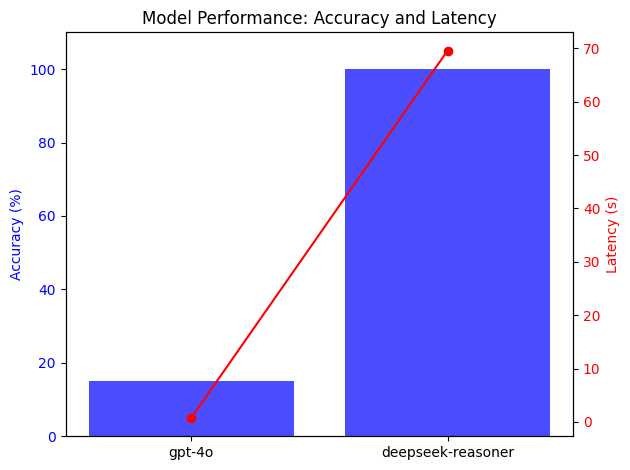

In [80]:
import matplotlib.pyplot as plt

# Data
model_data = results

# Extract data for plotting
models = list(model_data.keys())
accuracy = [model_data[model][0] * 100 for model in models]  # Convert accuracy to percentage
latency = [model_data[model][1] for model in models]  # Latency in seconds

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot accuracy as a bar chart
ax1.bar(models, accuracy, color='blue', alpha=0.7, label='Accuracy (%)')
ax1.set_ylabel('Accuracy (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 110)  # Adjust for clarity

# Plot latency as a line chart
ax2 = ax1.twinx()
ax2.plot(models, latency, color='red', marker='o', label='Latency (s)')
ax2.set_ylabel('Latency (s)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and legend
plt.title('Model Performance: Accuracy and Latency')
fig.tight_layout()  # Adjust layout to prevent overlap

# Show the plot
plt.show()
